# import module
##### if celluloid isn't exist, install it
##### ex: pip install celluloid

In [19]:
import numpy as np
import random
from matplotlib import pyplot as plt

import os
try:
    from celluloid import Camera
except:
    os.system("pip install celluloid")

# generate purpose
---
### check PBC method

In [20]:
def pbc(position, room):
    x_range = room["x"]["max"] - room["x"]["min"]
    y_range = room["y"]["max"] - room["y"]["min"]
    
    if (position["x"] > room["x"]["max"]):
        position["x"] -= x_range
    if (position["x"] < room["x"]["min"]):
        position["x"] += x_range
    if (position["y"] > room["y"]["max"]):
        position["y"] -= y_range
    if (position["y"] < room["y"]["min"]):
        position["y"] += y_range
    
    return position

### person movement

In [21]:
def move(old_position, move_probability, room):
    new_position = { 
        "x": old_position["x"],
        "y": old_position["y"]
    }

    if np.random.uniform(0, 1) <= move_probability:
        rand = np.random.uniform(0, 1)
        
        if (rand <= 0.25):
            new_position["x"] += 1
        elif (rand <= 0.5):
            new_position["x"] -= 1
        elif (rand <= 0.75):
            new_position["y"] += 1
        else:
            new_position["y"] -= 1
    
    return pbc(new_position, room)

### spread when someone in same place with infected person

In [22]:
def spread(datas):
    patients = [data for data in datas if data["infected"] == True]

    for data in datas:
        if data["infected"] == False and data["immune"] == False:
            for patient in patients:
                if data["x"] == patient["x"] and data["y"] == patient["y"]:
                    data["infected"] = True
                    break
    
    return datas

### initializing data on the first day

In [23]:
def firstDay(number_of_people, infected_ratio, room):
    people = []

    for i in range(number_of_people):
        random_position = lambda c: random.choice(range(room[c]["min"], room[c]["max"] + 1))

        data = {
            "x": random_position("x"),
            "y": random_position("y"),
            "infected": random.uniform(0, 1) <= infected_ratio,
            "immune": False
        }

        people.append(data)
    
    return spread(people)

### get key total of data

In [24]:
def lengthData(datas, key, key_condition):
    return len([data for data in datas if data[key] == key_condition])

### generate (main method)

In [25]:
def generate(number_of_people, infected_ratio, move_probability, recovery_time, room):
    days = [firstDay(number_of_people, infected_ratio, room)]

    i = 0
    while lengthData(days[i], "infected", True) > 0 :
        people = []
        for j, person in enumerate(days[i]):
            new_data = person.copy()
            
            old_position = {"x": person["x"], "y": person["y"]}
            new_position = move(old_position, move_probability, room)

            new_data["x"] = new_position["x"]
            new_data["y"] = new_position["y"]

            if person["infected"]:
                if i >= recovery_time and days[i - recovery_time][j]["infected"]:
                    new_data["infected"] = False
                    new_data["immune"] = True
            
            people.append(new_data)

        days.append(spread(people))
        i += 1
    
    return days

# calculating
---
### initializing data

In [26]:
number_of_people = 200
infected_ratio = 0.05
move_probability = 0.8
recovery_time = 10
room = {
    "x": {
        "min": 0,
        "max": 20
    },
    "y": {
        "min": 0,
        "max": 20
    }
}

days = generate(number_of_people, infected_ratio, move_probability, recovery_time, room)

### display the result

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


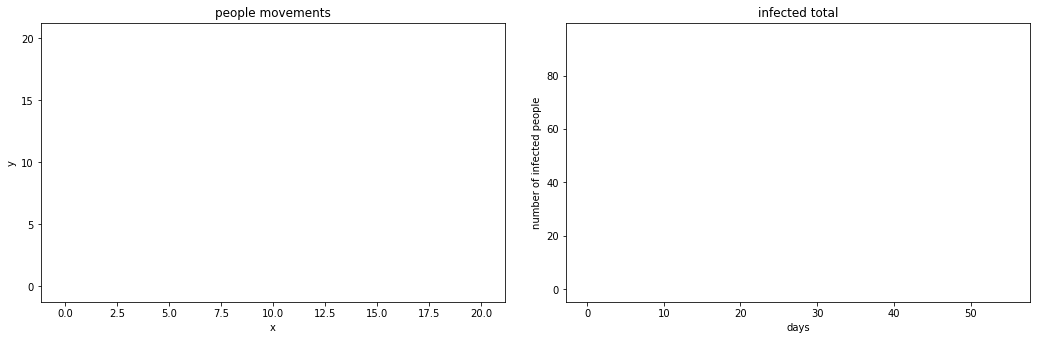

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.tight_layout(pad=3)
camera = Camera(fig)

patiens = {"day": [], "total": []}
for i, day in enumerate(days):
    uninfected = [person for person in day if person["infected"] == False and person["immune"] == False]
    recovered = [person for person in day if person["infected"] == False and person["immune"] == True]
    infected = [person for person in day if person["infected"] == True]

    axes[0].set_title("people movements")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].scatter([data["x"] for data in uninfected], [data["y"] for data in uninfected], c="blue")
    axes[0].scatter([data["x"] for data in recovered], [data["y"] for data in recovered], c="green")
    axes[0].scatter([data["x"] for data in infected], [data["y"] for data in infected], c="red")
    
    patiens["day"].append(i)
    patiens["total"].append(len(infected))

    axes[1].set_title("infected total")
    axes[1].set_xlabel("days")
    axes[1].set_ylabel("number of infected people")
    axes[1].plot(patiens["day"], patiens["total"], c="blue")

    camera.snap()
    
animation = camera.animate()
animation.save("virus spread model.gif")